In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Analyzing package downloads from PyPI with BigQuery DataFrames

In this notebook, you'll use the [PyPI public dataset](https://console.cloud.google.com/marketplace/product/gcp-public-data-pypi/pypi) and the [deps.dev public dataset](https://deps.dev/) to visualize Python package downloads for a package and its dependencies.

In [2]:
# Choose a package which you want to visualize.
package_name = "pandas"

In [3]:
import bigframes.pandas as bpd

# Preview feature warning:
# Use `ordering_mode="partial"` for more efficient query generation, but
# some pandas-compatible methods may not be possible without a total ordering.
bpd.options.bigquery.ordering_mode = "partial"

## Counting downloads and tracking dependencies

The [PyPI `file_downloads`](https://console.cloud.google.com/bigquery?ws=!1m5!1m4!4m3!1sbigquery-public-data!2spypi!3sfile_downloads) table contains a row for each time there is a download request for a package. The [deps.dev Dependencies](https://console.cloud.google.com/bigquery?ws=!1m5!1m4!4m3!1sbigquery-public-data!2sdeps_dev_v1!3sDependencies) table contains a row for each dependency of each package.

When `ordering_mode = "partial"`, `read_gbq_table` creates a DataFrame representing the table, but the DataFrame has no native ordering or index.

In [5]:
import bigframes.enums

# Without ordering_mode = "partial" it is recommended that you set
# the "filters" parameter to limit the number of rows subsequent queries
# have to read.
pypi = bpd.read_gbq_table(
    "bigquery-public-data.pypi.file_downloads",

    # Using ordering_mode = "partial" changes the default index to a "NULL"
    # index, meaning no index is available for implicit joins.
    #
    # Setting this explicitly avoids a DefaultIndexWarning.
    index_col=bigframes.enums.DefaultIndexKind.NULL,
)
deps = bpd.read_gbq_table(
    "bigquery-public-data.deps_dev_v1.Dependencies",
    index_col=bigframes.enums.DefaultIndexKind.NULL,
)

## Limit to the most recent 7 days of data

The PyPI and deps.dev tables are partitioned by date. Query only the most recent 7 days of data to reduce the number of bytes scanned.

Just as with the default ordering mode, filters can be describe in a pandas-compatible way by passing a Boolean Series to the DataFrame's `__getitem__` accessor.

In [6]:
import datetime

now = datetime.datetime.now(datetime.timezone.utc)
last_7_days = now - datetime.timedelta(days=7)
last_30_days = now - datetime.timedelta(days=30)
pypi = pypi[pypi["timestamp"] > last_7_days]
deps = deps[deps["SnapshotAt"] > last_30_days]  # deps are refreshed less frequently
deps = deps[deps["System"] == "PYPI"]


**⚠ Warning**

Without `ordering_mode = "partial"`, these filters do not change the number of bytes scanned. Instead, add column and row filters at "read" time. For example,

```
import datetime

last_7_days = datetime.datetime.now(datetime.timezone.utc) - datetime.timedelta(days=7)

# Without ordering_mode = "partial", one must limit the data at "read" time to reduce bytes scanned.
pypi = bpd.read_gbq_table(
    "bigquery-public-data.pypi.file_downloads",
    columns=["timestamp", "project"],
    filters=[("timestamp", ">", last_7_days)],
)
```

`head()` is not available when no ordering has been established. It fails with `OrderRequiredError`. Use `peek()` instead to download a sample of the data. This will be much more efficient, as the query doesn't need to order all rows to determine which are first.

In [7]:
# Warning: Ensure bpd.options.bigquery.ordering_mode = "partial" or else
# this query() will cause a full table scan because of the sequential index.
assert bpd.options.bigquery.ordering_mode == "partial"
pypi.peek()

,timestamp,country_code,url,project,file,details,tls_protocol,tls_cipher
0,2024-09-18 18:15:04+00:00,US,/packages/ff/c8/4cd4b2834012ffc71ae3fd69187f08...,aiobreaker,{'filename': 'aiobreaker-1.2.0-py3-none-any.wh...,"{'installer': {'name': 'pip', 'version': '21.1...",TLSv1.3,TLS_AES_128_GCM_SHA256
1,2024-09-18 18:29:50+00:00,US,/packages/21/8e/4562029e179226051cd4aa3135444d...,aiobotocore,"{'filename': 'aiobotocore-1.3.0.tar.gz', 'proj...","{'installer': {'name': 'pip', 'version': '24.1...",TLSv1.2,ECDHE-RSA-AES128-GCM-SHA256
2,2024-09-18 18:22:14+00:00,US,/packages/11/16/4226e59bb72e096d9809ccedf349a1...,aiobotocore,"{'filename': 'aiobotocore-2.0.1.tar.gz', 'proj...","{'installer': {'name': 'pip', 'version': '24.2...",TLSv1.2,ECDHE-RSA-AES128-GCM-SHA256
3,2024-09-18 18:22:08+00:00,US,/packages/11/16/4226e59bb72e096d9809ccedf349a1...,aiobotocore,"{'filename': 'aiobotocore-2.0.1.tar.gz', 'proj...","{'installer': {'name': 'pip', 'version': '24.2...",TLSv1.2,ECDHE-RSA-AES128-GCM-SHA256
4,2024-09-18 18:29:22+00:00,US,/packages/54/b7/453119271cc4c36b07fdeab9b0ff25...,aiobotocore,"{'filename': 'aiobotocore-2.3.3.tar.gz', 'proj...","{'installer': {'name': 'pip', 'version': '24.1...",TLSv1.2,ECDHE-RSA-AES128-GCM-SHA256


In [8]:
deps.peek()

,SnapshotAt,System,Name,Version,Dependency,MinimumDepth
0,2024-08-29 04:39:16.121656+00:00,PYPI,zxkane-cdk-construct-simple-nat,0.2.89,"{'System': 'PYPI', 'Name': 'attrs', 'Version':...",2
1,2024-08-29 04:39:16.121656+00:00,PYPI,zxkane-cdk-construct-simple-nat,0.2.82,"{'System': 'PYPI', 'Name': 'attrs', 'Version':...",2
2,2024-08-29 04:39:16.121656+00:00,PYPI,zxkane-cdk-construct-simple-nat,0.2.88,"{'System': 'PYPI', 'Name': 'attrs', 'Version':...",2
3,2024-08-29 04:39:16.121656+00:00,PYPI,zxkane-cdk-construct-simple-nat,0.2.91,"{'System': 'PYPI', 'Name': 'attrs', 'Version':...",2
4,2024-08-29 04:39:16.121656+00:00,PYPI,zxkane-cdk-construct-simple-nat,0.2.77,"{'System': 'PYPI', 'Name': 'attrs', 'Version':...",2


## Find dependencies for pandas

Use assign to add columns to the DataFrame after a scalar operations, such as extracting a sub-field from a `STRUCT` column.

Because the DataFrame has no index, this does not work if the new column belongs to a different table expression.

In [9]:
deps = deps.assign(DependencyName=deps["Dependency"].struct.field("Name"))

Use an aggregation to identify the unique `DependencyName`s for the `pandas` package. Note: `drop_duplicates()` is not supported, as the order-based behavior such as `keep="first"` is not applicable when using `ordering_mode = "partial"`.

A DataFrame with no index still supports aggregation operations. Set `as_index=False` to keep the GROUP BY keys as regular columns, instead of turning them into an index.

In [10]:
package_deps = deps[deps["Name"] == package_name].groupby(["Name", "DependencyName"], as_index=False).size()
package_deps.peek()

,Name,DependencyName,size
0,pandas,pytz,168
1,pandas,numpy,168
2,pandas,python-dateutil,168
3,pandas,six,168
4,pandas,tzdata,56


## Count downloads for pandas and its dependencies

The previous step created `pandas_deps` with all the dependencies of `pandas` but not pandas itself.

Combine two DataFrames with the same column names with the `bigframes.pandas.concat` function.

In [11]:
pandas_and_deps = bpd.concat(
    [
        package_deps.drop(columns=["Name", "size"]).rename(columns={"DependencyName": "Name"}),
        bpd.DataFrame({"Name": [package_name]}),
    ],

    # To join DataFrames that have a NULL index, set ignore_index = True.
    ignore_index=True,
)

Since there is no index to implicitly join on, use the `merge` method to join two DataFrames by column name.

In [12]:
pandas_pypi = pandas_and_deps.merge(pypi, how="inner", left_on="Name", right_on="project")

Create a time series to visualize by grouping by the date, extracted from the `timestamp` column.

**Note:** If you don't `peek()` at your data and only do grouped aggregations, BigQuery DataFrames can eliminate unnecessary ordering from the compilation even without `ordering_mode = "partial"`.

When BigQuery DataFrames aggregates over columns, those columns provide a
unique key post-aggregation that is used for ordering. Any ordering applied before is overridden. By aggregating over
a time series, the line plots will render in the expected order.

In [13]:
pandas_pypi = pandas_pypi.assign(date=pandas_pypi["timestamp"].dt.date)
downloads_per_day = pandas_pypi.groupby(["date", "project"]).size()

# Cache after the aggregation so that the aggregation only runs once.
downloads_per_day.cache()
downloads_per_day.to_pandas()

date        project        
2024-09-17  numpy               2572982
            pandas              2195692
            python-dateutil     3608119
            pytz                1863133
            six                 3064640
            tzdata               991989
2024-09-18  numpy              13282573
            pandas             10856758
            python-dateutil    17877058
            pytz                9450103
            six                15225000
            tzdata              5230039
2024-09-19  numpy              13637868
            pandas             11077817
            python-dateutil    18449777
            pytz                9690329
            six                15706263
            tzdata              5473910
2024-09-20  numpy              12609524
            pandas             10758593
            python-dateutil    17257536
            pytz                9082050
            six                14489456
            tzdata              5206738
2024-09-21  

BigQuery DataFrames has several built-in visualization methods. Alternatively, download the time series with the `to_pandas()` method for further analysis and visualization.

<Axes: xlabel='date', ylabel='daily downloads'>

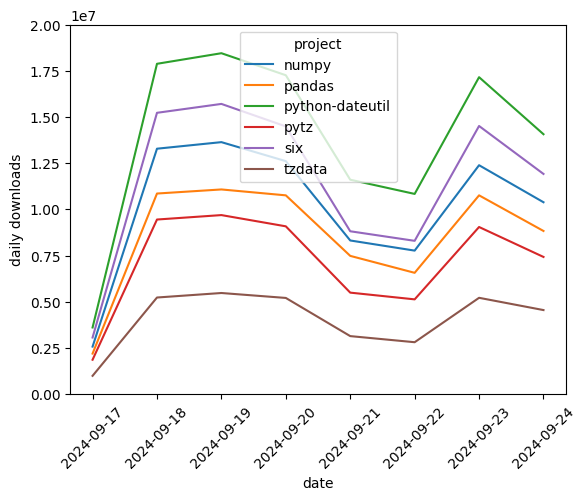

In [14]:
downloads_per_day.unstack().plot.line(rot=45, ylabel="daily downloads", ylim=(0, 2e7))